In [1]:
NAME = "Tyler Larsen"
COLLABORATORS = ""

---

# Project 2: Spam // Ham Prediction  

## Due Date: 11:59pm Sunday, April 29

In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.


# Part I - Initial Analysis

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [3]:
# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 150
sns.set()

### Loading in the Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labelled dataset contains 8348 labelled examples, and the evaluation set contains 1000 unlabelled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labelled data that you will use to train your model. It contains three columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email
1. `email`: The text of the email.
1. `spam`: 1 if the email was spam, 0 if the email was ham (not spam).

The `evaluation` DataFrame contains another set of 1000 unlabelled examples. You will predict labels for these examples and submit your predictions to Kaggle for evaluation.

In [4]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'eval.csv')

original_training_data = pd.read_csv('data/train.csv')
evaluation = pd.read_csv('data/eval.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
evaluation['email'] = evaluation['email'].str.lower()

original_training_data.head()

Using version already downloaded: Sun Jul 22 10:15:16 2018
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sun Jul 22 10:15:16 2018
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


## Train-Test Split

The training data we downloaded is all the data we have available for both training models and **testing** the models that we train.  We therefore need to split the training data into separate training and test datsets.  You will need this **test data** to evaluate your model once you are finished training.

In [5]:
from sklearn.model_selection import train_test_split

[train, test] = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Question 1

In the cell below, print the text of the first ham and the first spam email in the training set. Then, discuss one thing you notice that is different between the two that might relate to the identification of spam.

In [6]:
# Print the text of the first ham and the first spam emails. Then, fill in your response in the q01 variable:
first_ham = train[train['spam']==0].reset_index()['email'][0]
first_spam = train[train['spam']==1].reset_index()['email'][0]

In [7]:
# This is a cell with just a comment but don't delete me if you want to get credit.

One thing that is different is that the first email immediately gets into the body of the message starting at the first character, while the spam email has some sort of encoding information at the start of the email.

# Basic Feature Engineering

We would like to take the text of an email and predict whether the text is ham or spam. This is a *classification* problem, so we can use logistic regression to make a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $\Phi$ (pronounced phi as in wifi) and corresponding binary labels $Y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\Phi$ is derived from one email example. Each column of $\Phi$  is one feature. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

# Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```python
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello world hello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.array([pd.Series([1 if word in text else 0 for word in words]) for text in texts])
    return indicator_array

In [9]:
# If this doesn't error, your function outputs the correct output for this example
assert np.allclose(words_in_texts(['hello', 'bye', 'world'], 
                                  pd.Series(['hello', 'hello world hello'])),
                   np.array([[1, 0, 0], 
                             [1, 0, 1]]))

# Basic EDA

Now we need to identify some features that allow us to tell spam and ham emails apart. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


# Question 3a

Create a bar chart comparing the proportion of spam and ham emails containing certain words. It should look like the following plot (which was created using `sns.barplot`), but you should choose your own words as candidate features.

![training conditional proportions](training_conditional_proportions.png "Class Conditional Proportions")


In [10]:
def get_word_proportions(words, data):
    phi = words_in_texts(words, data)
    total = []
    for i in range(len(words)):
        total.append(sum([row[i] for row in phi]) / len(phi))
    return total

In [11]:
words = ['help', 'offer', 'claim', '$', 'now', 'request']
ham_props = get_word_proportions(words, train[train['spam']==0].reset_index()['email'])
spam_props = get_word_proportions(words, train[train['spam']==1].reset_index()['email'])

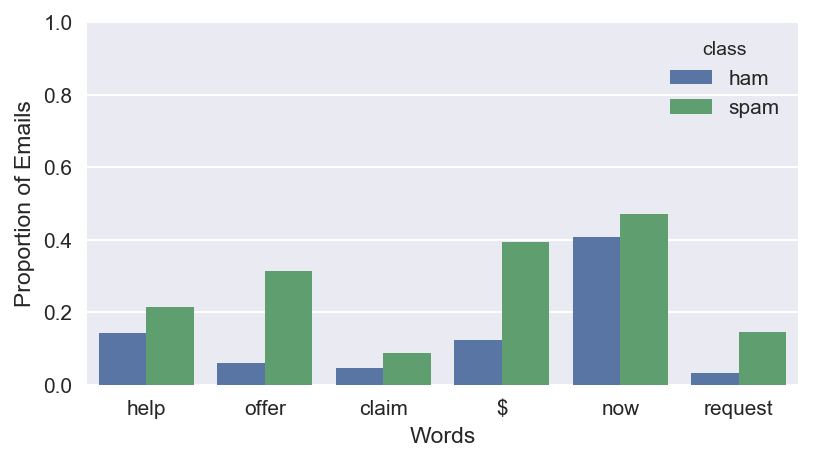

In [12]:
df = pd.DataFrame({"word": words, "ham": ham_props, "spam": spam_props})
df = pd.melt(df, id_vars="word", var_name="class", value_name="prop")

g = sns.factorplot(x='word', y='prop', hue='class', data=df, kind='bar', legend_out=False)
g.set(ylim=(0, 1))
g.fig.set_size_inches(6,3)
g.set_axis_labels('Words', 'Proportion of Emails')
plt.show()

# Question 3b

When the feature is binary, it makes sense (as in the previous question) to compare the proportion of 1s in the two classes of email. Otherwise, if the feature can take on many values, it makes sense to compare the distribution under spam to the distribution under ham. Create a *class conditional density plot* like the one below (which was created using `sns.distplot`), comparing the distribution of a feature among all spam emails to the distribution of the same feature among all ham emails. **You may use the Fraction of Uppercase Letters or create your own feature.**

![training conditional densities](training_conditional_densities2.png "Class Conditional Densities")

In [13]:
# reimport data to get the capital letters back
unclean_train = pd.read_csv('data/train.csv')

In [14]:
import re

In [15]:
def get_capital_prop(data):
    total_capitals = []
    for i in range(len(data)):
        total_capitals.append(len(re.findall(r'[A-Z]',data[i]))/ len(data[i]))
    return total_capitals

In [16]:
%%time
spam_capitals = get_capital_prop(unclean_train[unclean_train['spam']==0].reset_index()['email'])
ham_capitals = get_capital_prop(unclean_train[unclean_train['spam']==1].reset_index()['email'])

CPU times: user 997 ms, sys: 6.92 ms, total: 1 s
Wall time: 1.01 s


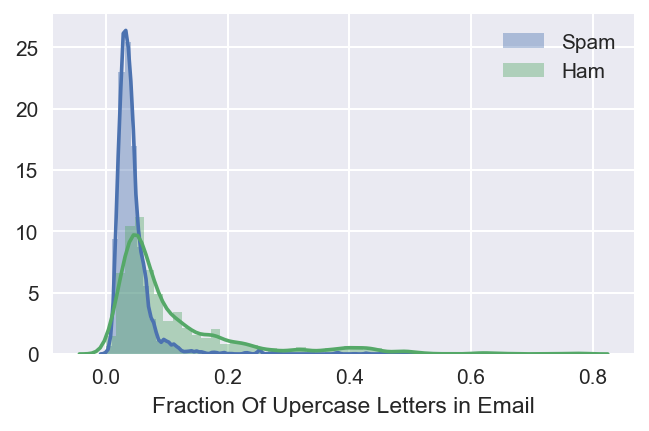

In [17]:
plt.rcParams['figure.figsize'] = (5, 3)

sns.distplot(spam_capitals, label='Spam')
sns.distplot(ham_capitals, label='Ham')
plt.xlabel('Fraction Of Upercase Letters in Email')
plt.legend()
plt.show()

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

# Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `Phi_train` and `Y_train`.

`Phi_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

In [18]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

Phi_train = words_in_texts(some_words, train.reset_index()['email'])
Y_train = train['spam']

Phi_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 7657    0
 6911    0
 6074    0
 4376    0
 5766    0
 Name: spam, dtype: int64)

In [19]:
assert np.all(np.unique(Phi_train) == np.array([0, 1]))
assert np.all(np.unique(Y_train) == np.array([0, 1]))
assert Phi_train.shape[0] == Y_train.shape[0]
assert Phi_train.shape[1] == len(some_words)

# Question 5

Now we have matrices we can give to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `Phi_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy of around 0.75.

In [20]:
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

In [21]:
model = lm.LogisticRegression()
model.fit(Phi_train, Y_train)
Y_pred = model.predict(Phi_train)

training_accuracy = metrics.accuracy_score(Y_train, Y_pred)

In [22]:
assert training_accuracy > 0.72

# Question 6

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labelled `spam` from reaching someone's inbox. Since we are trying  There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabelled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham. Answer the following questions in the cells below:

- (a) Suppose we have a classifier that just predicts 0 (ham) for every email. How many false positives are there? How many false negatives are there? Provide specific numbers using the training data from Question 4.
- (b) Suppose we have a classifier that just predicts 0 (ham) for every email. What is its accuracy on the training set? What is its recall on the training set?
- (c) What are the precision, recall, and false-alarm rate of the logistic regression classifier in Question 5? Are there more false positives or false negatives? 
- (d) Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
- (e) Given the word features we gave you above, name one reason this classifier is performing poorly.
- (f) Which of these two classifiers would you prefer for a spam filter and why? (N.B. there is no "right answer" here but be thoughtful in your reasoning).

TL;DR:  
__Precison__: Of all of the emails identified as spam, how many were actually spam?  
__Recall__: Of all the emails the are actually spam, how many were correctly classified?  
__False-Alarm Rate__: Of all the emails that are actually not spam, how many were identified as being spam?

In [23]:
len(Y_train[Y_train==1])

1918

In [24]:
# provide number of FP and FN, respectively,
# for a classifier that always predicts 0 (never predicts positive...)
zero_predictor_fp = 0
zero_predictor_fn = len(Y_train[Y_train==1])
print(zero_predictor_fp, zero_predictor_fn)

0 1918


In [25]:
# This is a cell with just a comment but don't delete me if you want to get credit.

In [26]:
# provide training accuracy & recall, respectively,
# for a classifier that always predicts 0
zero_predictor_acc = len(Y_train[Y_train == 0]) / len(Y_train)
zero_predictor_recall = 0
print(zero_predictor_acc)

0.7447091707706642


In [27]:
# This is a cell with just a comment but don't delete me if you want to get credit.

In [28]:
# provide training accuracy & recall, respectively,
# for logistic regression classifier from question 5
logistic_predictor_precision = metrics.precision_score(Y_train, Y_pred)
logistic_predictor_recall = metrics.recall_score(Y_train, Y_pred)
logistic_predictor_far = np.sum((Y_pred != Y_train) & (Y_train == 0)) / np.sum(Y_train == 0)
print(logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far)

0.6422287390029325 0.11418143899895725 0.021805183199285077


In [29]:
# This is a cell with just a comment but don't delete me if you want to get credit.

a) A classifier that predicts 0 for every email will have 0 false positives and 1980 false negatives.  
b) This same classifier will have an accuracy of .7447, and recall of 0.  
c) The precision, recall, and false-alarm rate of the logistic regression classifier in Question 5 are 0.6422, 0.114181, and 0.0218051, respectively. There are more false negatives than false positives.  
d) When using a logistic regression classifier, our accuracy was only 1% greater than using the classifer that always predicts 0.  
e) The classifer is performing poorly because there are too few words, as a result the model is underfitting.  
f) I would rather the all ham classifier because otherwise 2% of my improtant emials will be be sent to the spam folder where I may never see them.

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the evaluation set. To see your accuracy on the evaluation set, you will use your classifier to predict every email in the `evaluation` DataFrame and upload your predictions to Kaggle.

To prevent you from fitting to the evaluation set, you may only upload predictions to Kaggle twice per day. This means you should start early and rely on your **test data** to estimate your Kaggle scores.  

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features. However, **you are only allowed to train logistic regression models and their regularized forms**. This means no random forest, k-nearest-neighbors, neural nets, etc.

We will not give you a code skeleton to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **test data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [30]:
#from wordcloud import WordCloud
import re

In [31]:
# reset our data
original_training_data = pd.read_csv('data/train.csv')
original_training_data['email'] = original_training_data['email'].astype('str') 
original_training_data['subject'] = original_training_data['subject'].astype('str') 

In [32]:
# helper functions

def count_character(data, char):
    counts = []
    for i in range(len(data)):
        counts.append(data[i].count(char))
    return counts

def total_characters(data):
    counts = []
    for i in range(len(data)):
        counts.append(len(data[i]))
    return counts

def remove_html(data):
    clean = []
    for i in range(len(data)):
        cleanr = re.compile('<.*?>')
        clean.append(re.sub(cleanr, '', data[i]))
    return clean
        

In [33]:
def top_counts(data, limit=150):
    all_words = ' '.join(list(data))
    counts = dict()
    words = all_words.split()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    counts = pd.Series(list(counts.values()), index=list(counts.keys()))
    counts = counts.sort_values(ascending=False)[:limit]
    return set(counts.index)

In [34]:
ham_words_subj = top_counts(original_training_data[original_training_data['spam']==0]['subject'])
spam_words_subj = top_counts(original_training_data[original_training_data['spam']==1]['subject'])
unique_subj = spam_words_subj.symmetric_difference(ham_words_subj)

In [35]:
len(unique_subj)

230

In [36]:
ham_words_body = top_counts(original_training_data[original_training_data['spam']==0]['email'])
spam_words_body = top_counts(original_training_data[original_training_data['spam']==1]['email'])
unique_body = spam_words_subj.symmetric_difference(ham_words_body)

In [37]:
def data_process(data):
    '''
    Added features:
    
    1. Percentage of capital letters
    2. number of exclamations
    3. number of dollar signs
    4. Total character count in email
    5. Total character count in subject
    6. Some random words
    
    '''
    processed_data = pd.DataFrame()
    processed_data['carrit_ct'] = pd.Series(count_character(data['email'], '<')) + pd.Series(count_character(data['email'], '>'))
    
    data['email'] = data['email'].astype('str') 
    data['subject'] = data['subject'].astype('str') 
    data['email'] = remove_html(data['email'])
    
    processed_data['prop_upper'] = get_capital_prop(data['email'])
    processed_data['exclam_ct'] = count_character(data['email'], '!')
    processed_data['free_ct'] = count_character(data['email'], 'free')
    processed_data['dollar_ct'] = count_character(data['email'], '$')
    processed_data['body_char_ct'] = total_characters(data['email'])
    processed_data['subj_char_ct'] = total_characters(data['subject'])
    processed_data['body_cap_prop'] = get_capital_prop(data['email'])
    processed_data.body_cap_prop *= 10
    processed_data['subj_cap_prop'] = get_capital_prop(data['subject'])
    processed_data.subj_cap_prop *= 10
    
    data['email'] = data['email'].str.lower()
    data['subject'] = data['subject'].str.lower()
    
    body_words = list(unique_body)
    subj_words = list(unique_subj)
    
    body_word_df = pd.DataFrame(words_in_texts(body_words, data['email']), columns=body_words)
    subj_word_df = pd.DataFrame(words_in_texts(subj_words, data['subject']), columns=subj_words)
    
    processed_data = pd.concat([processed_data, body_word_df, subj_word_df], axis=1)
    
    return processed_data

In [38]:
# process and split
X = data_process(original_training_data)
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    original_training_data['spam'],
                                                    test_size=0.2, random_state=42)

In [39]:
model = lm.LogisticRegressionCV(cv=3)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

training_accuracy = metrics.accuracy_score(y_test, y_pred)

In [40]:
training_accuracy

0.944311377245509

# Question 7 (Feature/Model Selection Process)

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

In order to find the best features, I first looked for the best words to to use. In order to this, I created a function top_counts that would allow me to extract the most common words from both the ham and spam subjects and bodies, and then I used the words that were not in both sets as my filter words. This worked to some degree, but on the first try I inlcuded too many words and so my model overfit the data. Interestingly, I found that the words in the subject were just as important as those in the subject.

# Question 8 (EDA)

In the two cells below, show a visualization that you used to select features for your model. Include both

1. A plot showing something meaningful about the data that helped you during feature / model selection.
2. 2-3 sentences describing what you plotted and what its implications are for your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the cells below.

**You should not show us a visualization just like in question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Use a word-cloud or another visualization tool to characterize the most common spam words.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

In [41]:
def top_counts2(data, limit=20):
    all_words = ' '.join(list(data))
    counts = dict()
    words = all_words.split()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    counts = pd.Series(list(counts.values()), index=list(counts.keys()))
    counts = counts.sort_values(ascending=False)[:limit]
    return counts

def email_barchart(data, spam_or_ham, one_or_zero):
    data = remove_html(data)
    data = top_counts2(data, 80)
    keepers = set(data.index).intersection(spam_or_ham)
    new_data = pd.Series()
    for word in data.index:
        if word in keepers:
            new_data[word] = data[word]
    plt.rcParams['figure.figsize'] = (6, 4)
    plt.rcParams['font.size'] = 12
    sns.set_color_codes("pastel")
    if one_or_zero == 0:
        sns.barplot(new_data.values, new_data.index, color="b").set_title("Top Subject Words by Frequency in Ham Emails")
    else:
        sns.barplot(new_data.values, new_data.index, color="b").set_title("Top Subject Words by Frequency in Spam Emails")
    

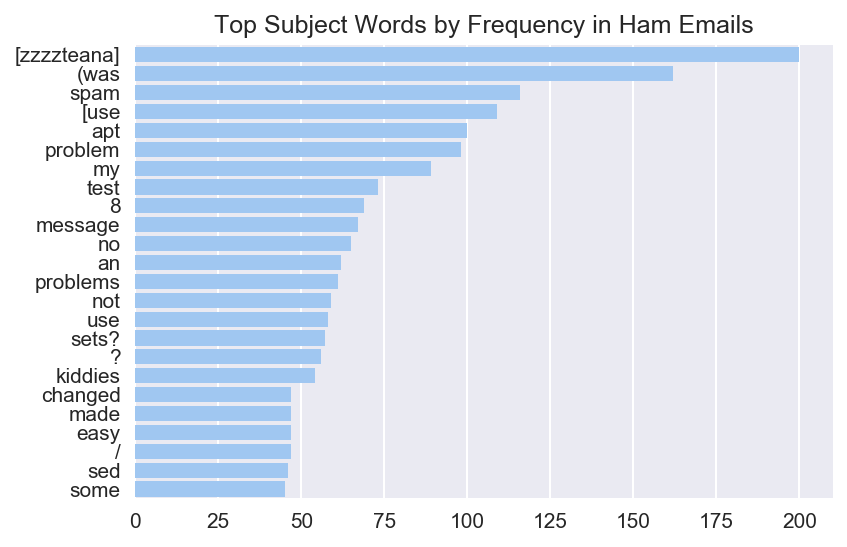

In [42]:
email_barchart(original_training_data[original_training_data['spam']==0].reset_index()['subject'], unique_subj, 0)

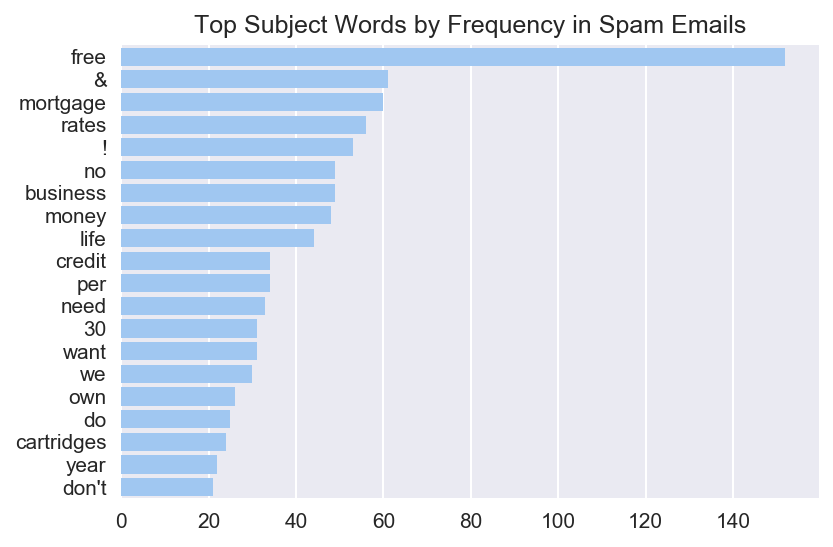

In [43]:
email_barchart(original_training_data[original_training_data['spam']==1].reset_index()['subject'], unique_body, 1)

These two plots are bar charts showing the most common words in first the ham subject lines and then second the spam subject lines. I first made these plots using the email bodies, which led me to realized I should remove the html tags, and then after using it with the subjects I was able to better tune which words I selected for. When building my model, I was careful to only use the words that were common in either spam or ham, and discard the words that were common to both.     
  Originally, I used the wordcloud library to visualize this same data, but pip installing the wordcloud library was causing my notebook to fail vaidation, and so I switched it to a bar chart.

# Question 9 (Making a Precision-Recall Curve)

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The precision-recall curve shows this trade off for each possible cutoff probability. In the cell below, [plot a precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) for your final classifier (the one you use to make predictions for Kaggle).

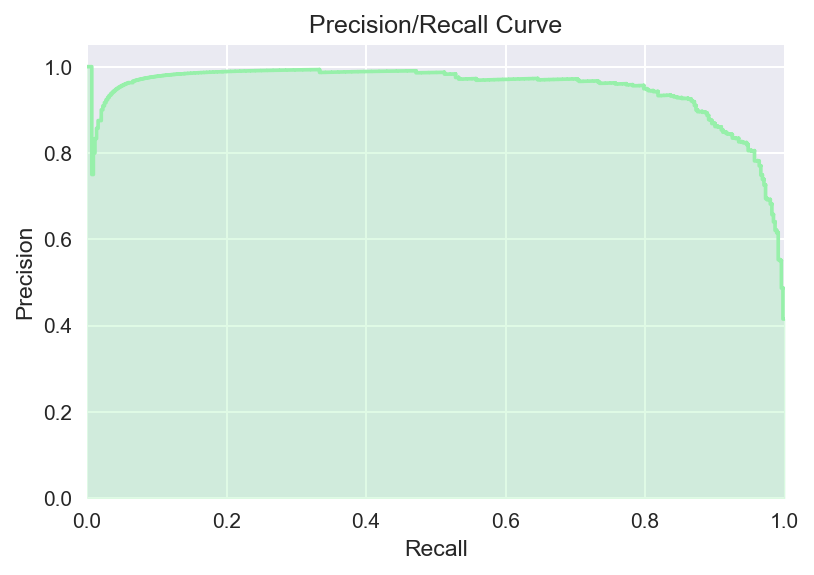

In [44]:
from sklearn.metrics import precision_recall_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes
y_prob = model.predict_proba(x_test)
precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1])
plt.step(recall, precision, color='g')
plt.fill_between(recall, precision, alpha=.3, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1])
plt.title('Precision/Recall Curve')
plt.show()

# Question 10: Submitting to Kaggle

The following code will write your predictions on the evaluation dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `evaluation_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `evaluation_predictions` as this is how your grade for this part will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the evaluation data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/t/39fae66747b14fd48fe0984f2e4f16ac

In [45]:
# fit model with all of our data beofre making final predictions
model.fit(X, original_training_data['spam'])
evaluation['email'] = evaluation['email'].astype('str') 
evaluation['subject'] = evaluation['subject'].astype('str') 
x_final = data_process(evaluation)
evaluation_predictions = model.predict(x_final)

In [46]:
# must be ndarray of predictions
assert isinstance(evaluation_predictions, np.ndarray) 

# must be binary labels (0 or 1) and not probabilities
assert np.all((evaluation_predictions == 0) | (evaluation_predictions == 1))

# must be the right number of predictions
assert evaluation_predictions.shape == (1000, )

In [47]:
# Please do not modify this cell

The following saves a file to submit to Kaggle.

In [48]:
from datetime import datetime

# Assuming that your predictions on the evaluation set are stored in a 1-dimensional array called
# evaluation_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# must be ndarray of predictions
assert isinstance(evaluation_predictions, np.ndarray) 

# must be binary labels (0 or 1) and not probabilities
assert np.all((evaluation_predictions == 0) | (evaluation_predictions == 1))

# must be the right number of predictions
assert evaluation_predictions.shape == (1000, )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": evaluation['id'], 
    "Class": evaluation_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2018-07-22T10:46:48.csv.
You may now upload this CSV file to Kaggle for scoring.
